In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import cv2
import os
import sys
from sklearn.metrics import confusion_matrix

In [ ]:
import torchvision.transforms as transforms

def preprocess_frame(frame):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    preprocessed_frame = transform(frame)
    return preprocessed_frame


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2

def extract_frames(video_path, num_frames):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [int(i * (total_frames / num_frames)) for i in range(num_frames)]

    for index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            # Preprocess the frame if needed (resize, normalize, etc.)
            frame = preprocess_frame(frame)
            frames.append(frame)

    cap.release()
    return frames


In [ ]:
import matplotlib.pyplot as plt



# Specify the path to the video file
video_path = "/content/drive/MyDrive/CVD/digits/0/V1-0001_digit31801.mov"

# Define the number of frames to extract
num_frames = 10

# Extract frames from the video
frames = extract_frames(video_path, num_frames)

# # Plot the extracted frames
# fig, axes = plt.subplots(2, 5, figsize=(12, 6))
# axes = axes.ravel()

# for i in range(num_frames):
#     frame = frames[i].transpose(1, 2, 0)  # Transpose the dimensions
#     axes[i].imshow(frame)
#     axes[i].axis("off")

# plt.tight_layout()
# plt.show()


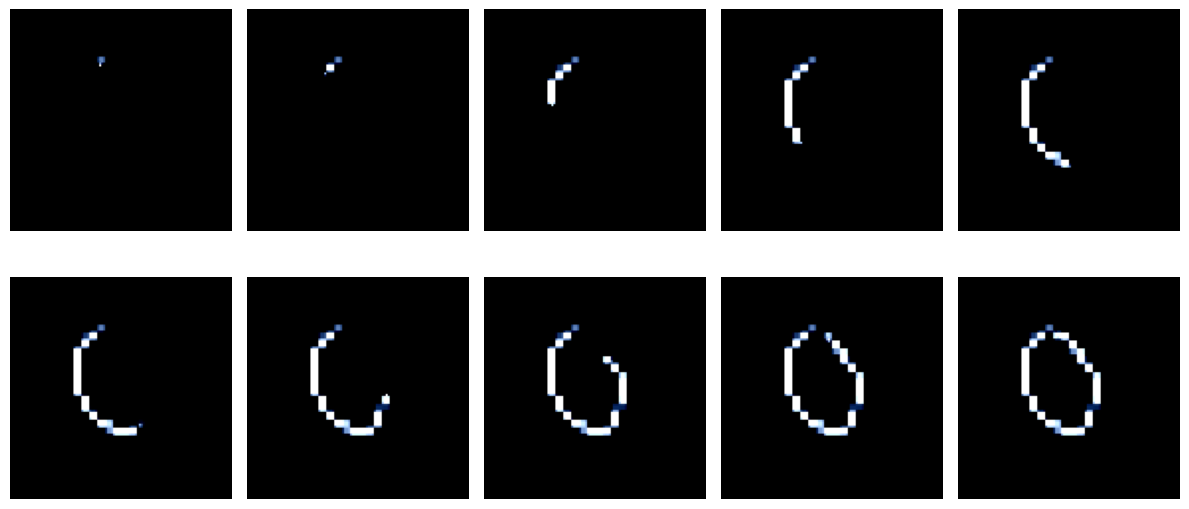

In [ ]:
# Plot the extracted frames
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(num_frames):
    frame_array = frames[i].numpy()
    frame = frame_array.transpose((1, 2, 0))  # Transpose the dimensions
    axes[i].imshow(frame)
    axes[i].axis("off")


plt.tight_layout()
plt.show()

In [ ]:
import os
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.video_paths, self.labels = self._get_video_paths_and_labels()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index):
        video_path = self.video_paths[index]
        label = self.labels[index]

        frames = extract_frames(video_path, self.num_frames)
        frames = torch.stack(frames)

        return frames, label

    def _get_video_paths_and_labels(self):
        video_paths = []
        labels = []
        class_dirs = os.listdir(self.root_dir)

        for label, class_dir in enumerate(class_dirs):
            class_path = os.path.join(self.root_dir, class_dir)
            if os.path.isdir(class_path):
                video_files = os.listdir(class_path)
                for video_file in video_files:
                    video_path = os.path.join(class_path, video_file)
                    video_paths.append(video_path)
                    labels.append(label)

        return video_paths, labels


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define the number of frames to extract from each video
num_frames = 20

# Define the root directory of your video data
root_dir = '/content/drive/MyDrive/CVD/digits'


# Instantiate the dataset
dataset = VideoDataset(root_dir, num_frames)

# Perform train-test split
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define batch size and number of workers for data loaders
batch_size = 1
num_workers = 2

# Instantiate the train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# # Instantiate the train and validation datasets
# train_dataset = VideoDataset(root_dir, num_frames)
# valid_dataset = VideoDataset(root_dir, num_frames)


In [ ]:
class VideoModel(nn.Module):
    def __init__(
        self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False
    ):
        super(VideoModel, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)  # Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        return fmap, self.dp(self.linear1(torch.mean(x_lstm, dim=1)))

model = VideoModel(10).cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 172MB/s]


In [ ]:

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()

        _, outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))

        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
            % (
                epoch,
                num_epochs,
                i,
                len(data_loader),
                losses.avg,
                accuracies.avg,
            )
        )

    return losses.avg, accuracies.avg

def test(epoch, model, data_loader, criterion):
    print('\nTesting')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()

            _, outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))

            _, p = torch.max(outputs, 1)
            true += targets.type(torch.cuda.LongTensor).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            sys.stdout.write(
                "\r[Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
                % (i, len(data_loader), losses.avg, accuracies.avg)
            )

    print('\nAccuracy: {}'.format(accuracies.avg))

    return true, pred, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()

    return 100 * n_correct_elems / batch_size



In [ ]:
# Set the learning rate and number of epochs
lr = 1e-5
num_epochs = 20

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

# Define the loss criterion
criterion = nn.CrossEntropyLoss().cuda()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/20] [Batch 72/73] [Loss: 2.3333, Acc: 10.96%]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Testing
[Batch 18/19] [Loss: 2.3022, Acc: 15.79%]
Accuracy: 15.789473684210526
[Epoch 2/20] [Batch 72/73] [Loss: 2.3055, Acc: 12.33%]
Testing
[Batch 18/19] [Loss: 2.3271, Acc: 5.26%]
Accuracy: 5.2631578947368425
[Epoch 3/20] [Batch 72/73] [Loss: 2.2857, Acc: 10.96%]
Testing
[Batch 18/19] [Loss: 2.2967, Acc: 0.00%]
Accuracy: 0.0
[Epoch 4/20] [Batch 72/73] [Loss: 2.2650, Acc: 19.18%]
Testing
[Batch 18/19] [Loss: 2.2836, Acc: 21.05%]
Accuracy: 21.05263157894737
[Epoch 5/20] [Batch 72/73] [Loss: 2.2838, Acc: 9.59%]
Testing
[Batch 18/19] [Loss: 2.3076, Acc: 15.79%]
Accuracy: 15.789473684210526
[Epoch 6/20] [Batch 72/73] [Loss: 2.2441, Acc: 17.81%]
Testing
[Batch 18/19] [Loss: 2.3189, Acc: 5.26%]
Accuracy: 5.2631578947368425
[Epoch 7/20] [Batch 72/73] [Loss: 2.2550, Acc: 28.77%]
Testing
[Batch 18/19] [Loss: 2.2943, Acc: 21.05%]
Accuracy: 21.05263157894737
[Epoch 8/20] [Batch 72/73] [Loss: 2.2181, Acc: 23.29%]
Testing
[Batch 18/19] [Loss: 2.3057, Acc: 5.26%]
Accuracy: 5.2631578947368425
[Epo

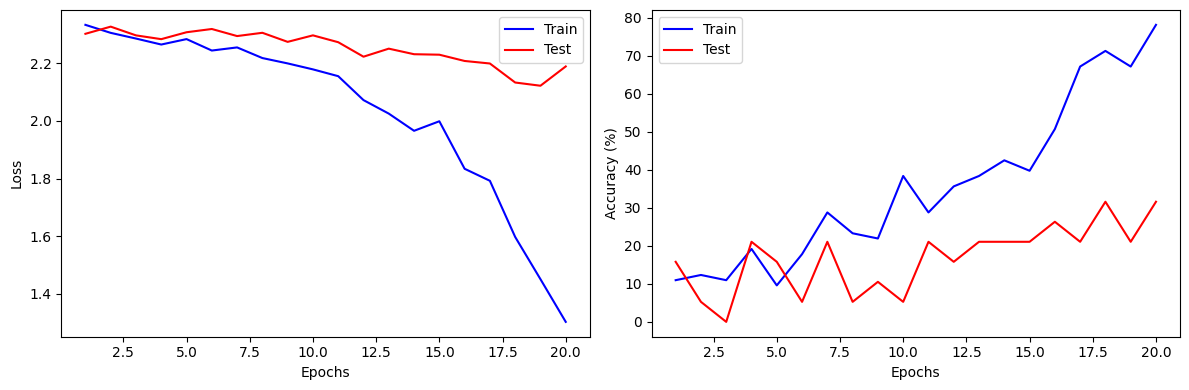

In [ ]:
import matplotlib.pyplot as plt

# Lists to store training and testing metrics
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Start training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)

    true_labels, predicted_labels, test_loss, test_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)

# Plot the metrics after each epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 1), train_loss_avg, 'b-', label='Train')
plt.plot(range(1, epoch + 1), test_loss_avg, 'r-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 1), train_accuracy, 'b-', label='Train')
plt.plot(range(1, epoch + 1), test_accuracy, 'r-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.transforms import functional as TF
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights